In [1]:
library(tidyverse)
library(forecast)
library(fpp2)
library(rnoaa)
library(lubridate)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'forecast' was built under R version 4.1.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'fpp2' was built under R version 4.1.2"
-- Attaching packages -------------------------------------------------------------------------------------- fpp2 2.4 --

v fma       2.4     v expsmooth 2.3

Warni

In [2]:
stations <- ghcnd_stations()

using cached file: C:\Users\Maoli\AppData\Local/Cache/R/noaa_ghcnd/ghcnd-stations.rds

date created (size, mb): 2022-02-12 20:25:20 (2.159)

using cached file: C:\Users\Maoli\AppData\Local/Cache/R/noaa_ghcnd/ghcnd-inventory.rds

date created (size, mb): 2022-02-12 20:26:28 (2.669)



In [3]:
kyoto <- read.csv("../data/raw/kyoto.csv")
liestal <- read.csv("../data/raw/liestal.csv")
washingtondc <- read.csv("../data/raw/washingtondc.csv")

In [4]:
kyoto <- kyoto |> 
  mutate(id = "JA000047759")
washingtondc <- washingtondc |> 
  mutate(id = "USC00186350")
liestal <- liestal |> 
  mutate(id = "GME00127786")

van_id <- "CA001108395"

In [5]:
para_list <- c("tmax", "tmin", "prcp")
id_list <- c("JA000047759", "GME00127786", "USC00186350", "CA001108395")

In [6]:
kyoto_weather <- ghcnd_search(stationid = "JA000047759", date_min = "1950-01-01", date_max = "2022-01-31")[["tmax"]]
kyoto_weather <- merge(kyoto_weather, ghcnd_search(stationid = "JA000047759", date_min = "1950-01-01", date_max = "2022-01-31")[["tmin"]], by = c("date", 'id'))
kyoto_weather <- merge(kyoto_weather, ghcnd_search(stationid = "JA000047759", date_min = "1950-01-01", date_max = "2022-01-31")[["prcp"]], by = c("date", 'id')) |> 
  select(date, id, tmax, tmin, prcp)|> 
  mutate(tmax = tmax / 10, tmin = tmin / 10) |> 
  mutate(month = month(date), year = year(date))

using cached file: C:\Users\Maoli\AppData\Local/Cache/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2022-02-21 00:47:14 (1.666)

file min/max dates: 1945-10-01 / 2022-02-28

using cached file: C:\Users\Maoli\AppData\Local/Cache/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2022-02-21 00:47:14 (1.666)

file min/max dates: 1945-10-01 / 2022-02-28

using cached file: C:\Users\Maoli\AppData\Local/Cache/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2022-02-21 00:47:14 (1.666)

file min/max dates: 1945-10-01 / 2022-02-28



In [7]:
kyoto_weather_train <- kyoto_weather |> 
  filter(year < 2018)

kyto_weather_test <- kyoto_weather |> 
  filter(year >= 2018)

In [72]:
kyoto_weather_train_ts <- ts(kyoto_weather_train$tmax, freq = 365)

In [73]:
model <- auto.arima(kyoto_weather_train_ts)

In [77]:
model

Series: kyoto_weather_train_ts 
ARIMA(1,0,0)(0,1,0)[365] 

Coefficients:
         ar1
      0.5321
s.e.  0.0056

sigma^2 = 14.08:  log likelihood = -63750.45
AIC=127504.9   AICc=127504.9   BIC=127521.1

In [78]:
tmax_hat <- forecast(model, h = nrow(kyto_weather_test))
tmax_hat

         Point Forecast        Lo 80     Hi 80        Lo 95    Hi 95
66.96438      12.063267  7.253785976 16.872749   4.70780026 19.41873
66.96712      11.835481  6.387472206 17.283490   3.50347037 20.16749
66.96986      12.693182  7.077544660 18.308819   4.10480586 21.28156
66.97260      12.083523  6.421322130 17.745723   3.42393422 20.74311
66.97534       9.684807  4.009491626 15.360123   1.00516093 18.36445
66.97808      10.138703  4.459679433 15.817727   1.45338577 18.82402
66.98082      10.767383  5.087309176 16.447456   2.08045992 19.45431
66.98356       7.382644  1.702272939 13.063014  -1.30473362 16.07002
66.98630      11.290764  5.610309486 16.971219   2.60325839 19.97827
66.98904      13.695085  8.014606867 19.375564   5.00754316 22.38263
66.99178       9.497385  3.816899534 15.177870   0.80983225 18.18494
66.99452       9.498608  3.818121194 15.179096   0.81105290 18.18616
66.99726       8.599260  2.918771744 14.279747  -0.08829683 17.28682
67.00000       4.699606 -0.9808819

In [67]:
max(as.vector(tmax_hat$mean))

[1] 20.72818

In [79]:
kyto_weather_test <- kyto_weather_test |> 
  mutate(hat = as.vector(tmax_hat$mean))

In [80]:
kyto_weather_test|> drop_na() |> summarise(rmse = sqrt(sum((tmax-hat)**2, na.rm = TRUE)) / n())

rmse
<dbl>
0.1669084


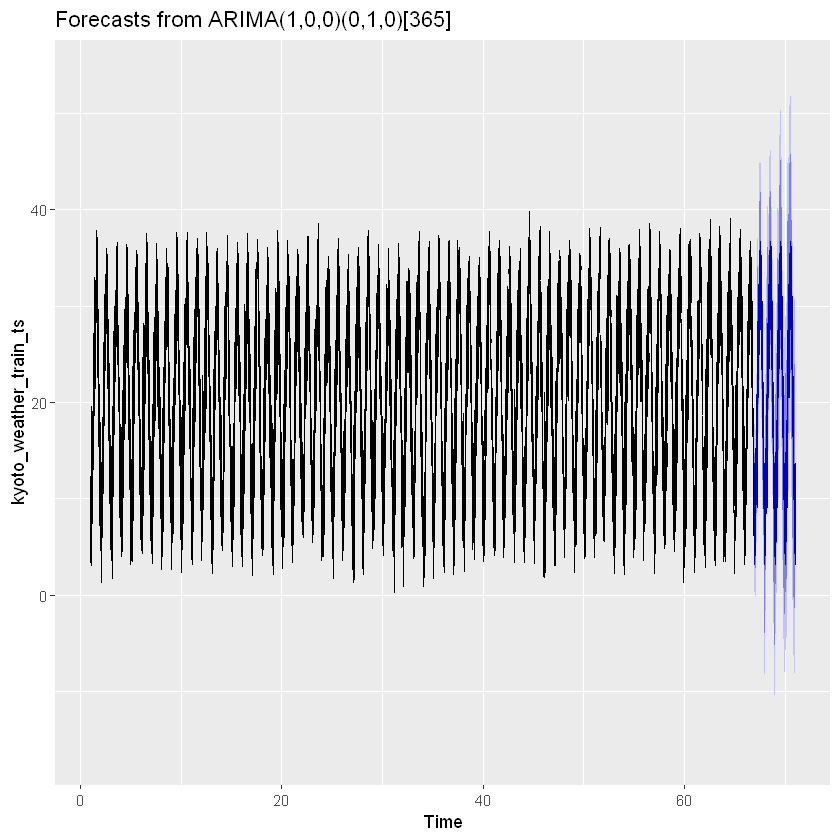

In [81]:
autoplot(tmax_hat)

In [82]:
ses_kyoto <- ses(kyoto_weather_train_ts,
                alpha = .15,
                h = nrow(kyto_weather_test))

Warning message in ets(x, "ANN", alpha = alpha, opt.crit = "mse", lambda = lambda, :
"Missing values encountered. Using longest contiguous portion of time series"


In [83]:
kyto_weather_test <- kyto_weather_test |> 
  mutate(ses_hat = as.vector(ses_kyoto$mean))

In [84]:
kyto_weather_test |> drop_na() |> summarise(rmse = sqrt(sum((tmax-ses_hat)**2, na.rm = TRUE)) / n())

rmse
<dbl>
0.3934943
